# Mediation analysis and (in)direct effects

## Outline

- [Setup](#setup)
- [Overview: mediation analysis](#overview:-mediation-analysis)
    - [Task: identify the (in)direct causal role of a variable](#task:-identify-the-\(in\)direct-causal-role-of-a-variable)
    - [Challenge: conditioning on mediators might open paths](#challenge:-mere-conditioning-may-fail-to-isolate-a-path)
    - [Definitions](#definitions)
    - [Assumptions](#assumptions)
- [Example: the effect of family interventions on future substance use](#example:-the-effect-of-family-interventions-on-future-substance-use)
    - [Variables](#variables)
    - [Motivations](#motivations)
    - [Source](#source)
- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model description](#model-description)
- [Causal Query: average natural direct effect (ANDE)](#causal-query:-average-natural-direct-effect-\(ANDE\))
- [Causal Inference as Probabilistic Inference](#causal-inference-as-probabilistic-inference)
- [Results](#results)


## Setup

Let's start with loading all the dependencies we use in this example. 

In [1]:
%reload_ext autoreload
%pdb off

import os
import torch
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

smoke_test = ('CI' in os.environ)
max_epochs = 5 if smoke_test else 1500
num_samples = 10 if smoke_test else 10000

Automatic pdb calling has been turned OFF


## Overview: mediation analysis

### Task: identify the (in)direct causal role of a variable

Understanding the mechanisms by which an intervention achieves its effect can have serious consequences for what treatments or policy changes are preferrable. For instance, a smoking prevention program, among other things that directly influence smoking, might influence a person's work break habits. 

![Impact of a smoking prevention program](figures/programDAG.png)

In this scenario we need to determine the extent to which the smoking prevention program's effect is mediated by work break habits, which is an example of an *indirect effect*. Or, in a work discrimination case, we might want to examine how much the mistreatment of minority members is the *direct effect* of their minority status, and how much it is mediated by, say, education, to which they have lower access.

![Impact of minority membership on mistreatment](figures/minorityDAG.png)

Note:  talking in terms of the distinction between the direct and the indirect effect is fairly standard. However, mediation analysis can be applied to cases in which there are two disjoint (sets of) paths from the input to the output variable, and we want to isolate and evaluate the impact that proceeds through one of them. As long as the appropriate structural assumptions are satisfied, this can be achieved, as our example will illustrate.

### Challenge: mere conditioning may fail to isolate a path

Let's take a seemingly straighforward case of discrimination where the underlying causal structure is as depicted above. One approach to understanding the direct impact of *Minority* on *Salary* would be to run a regression analysis with both *Minority* and *Education* as input variables, and *Salary* as the output. The resulting coefficient corresponding to *Minority* would be considered the impact of this variable, correcting for education levels. Note, however, that this approach assumes that there are no confounders between the mediator (*Education*) and the output (*Salary*). For instance, a confounder might be the subject's parents' socioeconomic status, which could impact both *Education* and *Salary*.

![Confounding in a discrimination case](figures/statusDAG.png)

In such a case, by conditioning in a regression analysis  on *Education*, we would go against the requirement that covariates to be conditioned on can't be post-treatment (see [the backdoor adjustment example](backdoor.ipynb) for more discussion of this consideration).

Generally, the solution is to disallow upstream information flow from the mediator, by intervening on it. There are some nuances, though: we need to reason about multiple interacting counterfactual worlds, as now we are considering nested interventions, where the order matters. As our example illustrates, this is not a complicated thing to do in ChiRho. 

### Definitions

To properly handle the situation we need to carefully deal with multiple variables and counterfactuals-and in this setting, it turns out there are a few different notions in the vicinity that we need to be able to distinguish.
Since the distinctions that we have made are somewhat convoluted, unlike in the other ChiRho examples, we will also frontload the explanation with the corresponding definitions, starting with a piece of notation. Suppose we are given a model $M$ with graph $G$. We are looking at treatment of the intervention $X=x$ on $Y$, given a context $U=u$, assuming the mediator $M$ is set to $m$. The value that $Y$ would have after the intervention fixing $X$ to $x$ in a  context $u$ is denoted as $Y_{x}(u)$. 

To better understand the impact of a treatment or a policy change, we need a further distinction. For instance, suppose a treatment ($T$) has a direct impact on disease ($D$), and also causes nausea, which in turn may motivate the patient to use a countermeasure ($C$) that may affect $D$. One question we can ask is about the *total effect* of $T$ on $D$, $P(D_{t} = d) - P(D_{t'} = d)$, where  $P(D_{t} = d)$ is the probability that $D=d$ in the intervened model in which $T$ is set to $t$. 

If we want to determine whether the use or certain levels of countermeasures should be discouraged, we need to conduct a mediation analysis. But which probabilities should we compare? On one hand, with respect to any level $c$ of $C$, we might want to know if a given untreated patient would get better if treated, holding $c$ fixed. If we proceed so, we are interested in the *controlled* direct of effect(s) of treatment on $D$ (different levels of $c$, in principle, could be connected with different direct effect levels), $P(D_{tc} = d) - P(D_{t'c} = d)$ for various settings $c$ of $C$ and different settings of $t$ and $t'$. Alternatively, we might want to take the *natural* levels of $C$ in a given patient into account (say, we know their use level of $C$ if untreated would take some particular value $c$). In this scenario, we use the same formula, but we are only interested in what value it leads to when $c$ is held constant at the pre-treatment level. In the latter scenario, which more realistically abides by the constraints our policy will have to obey, we are estimating the *natural direct effect*. 

One way to see the difference is imagining it is possible to eliminate the nauseating effect of the treatment (notice how this intervention cannot be expressed in terms of the $do$ operator relative to this model, as it consists in the de-activation of a path, rather than setting a variable to a particular value). The question now is, whether this would in any way change the effect of the treatment. Estimating the controlled direct effect would not answer the question, as this change does not result in the population uniformly using a prescribed level of countermeasures. And in general, if there is no feasible intervention that can keep $c$ at a prescribed level, the controlled direct effect is not the estimand that we are after. In contrast, if we assume that each user sticks to their pre-treatment levels of countermeasures and we ask about the direct effect, we're estimating the natural direct effect. The general phenomenon is that controlled direct effect is of interest to a policy maker if the value of the mediator can be fixed by an intervention, while the natural direct effect is of more interest if the intervention is more nuanced.


1. **Controlled unit-level direct-effect**.  $$CDE_z(Y, u; x, x') = Y_{xz}(u) - Y_{x'z}(u)$$ 

2. **Average controlled direct effect** $$ACDE_z(Y; x, x') =  \mathbb{E}[Y_{xz} - Y_{x'z}]$$

3. **Unit-level natural direct effect** $$NDE(Y, u; x, x') = Y_{x, Z_{x'}(u)}(u) - Y_{x'}(u)$$

Let's rephrase the above. Consider two situations. In one, we intervene to set both $X=x$ and $z$ to be $Z_{x'}(u)$, that is, the value that $Z$ would have had we fixed $X$ to be $x'$-that is, intuitively, we fix the mediator to its no-treatment natural value. The second situation involves only intervening on $X$, setting it to $x'$, which corresponds to treatment. $NDE$ is the diferrence between the values $Y$ would have in these two situations. 

4. **Average natural direct effect** 

$$ANDE ( Y; x, x' ) = \mathbb{E} [ Y_{x,Z_{x'}} -  Y_{x'} ] $$

5. **Unit-level natural indirect effect**

In the controlled setting, where we fix $Z$ to have a particular value, we may not be able to estimate the indirect effect. To do that, we would simultaneously have to hold some variables constant to block the direct path, which is not achievable.  
Under some conditions (specified below), however, it is possible to identify the natural indirect effect. First, we need to define it:

$$NIE ( Y, u; x, x' ) =  Y_{x',Z_{x}}(u)-  Y_{x'}(u)$$

$$ANIE ( Y; x, x' ) = \mathbb{E} [ Y_{x', Z_{x}} -  Y_{x'}]$$

The (natural) indirect effect is a reverse version of the direct effect, and with the (natural) direct effect sums to the total effect.

Note that *our notation is slightly non-standard*, as in contexts in which no distinction between unit-level and average measures of effect, ACDE and ANDE are usually referred to simply as CDE and NDE. We preferred to preserve this distinction for the sake of clarity.


The seminal paper discussing these distinctions and various types of mediation is  Pearl's [Direct and indirect effects](https://ftp.cs.ucla.edu/pub/stat_ser/R273-U.pdf). A somewhat more recent general framework is described in [Nested Counterfactual Identification from Arbitrary Surrogate Experiments](https://proceedings.neurips.cc/paper/2021/hash/36bedb6eb7152f39b16328448942822b-Abstract.html) by Juan Correa, Sanghack Lee, and Elias Bareinboim.

### Assumptions

In our example we assume that the functional form of the causal relationships is known, that there are no latent confounders, and that we have the causal ordering among the variables right. General identifiability conditions are somewhat weaker and can be found in Pearl's [Direct and indirect effects](https://ftp.cs.ucla.edu/pub/stat_ser/R273-U.pdf).

## Example: the effect of family interventions on future substance use

### Variables

Almost all binary variables have levels 0 (which stands for "No") and  1 (which stands for "Yes").
- `dev_peer` represents whether the subject engaged with deviant peer groups (a mediator variable).
- `sub_exp` marks whether a subject experimented with drugs (a mediator variable).
- `fam_int` represents participation in a family intervention during adolescence (this is the treatment).
- `sub_disorder` stands for the diagnosis of substance use disorder in young adulthood (this is the outcome).
- `gender` is binary with two values: `Female` and `Male` (this is a covariate).
- `conflict` represents the level of family conflict and is a continuous variable (although, in reality there are only a few possible values that it takes) (another covariate).

### Motivations

Suppose we are interested in the effect of the family intervention during adolescence on future substance use. More specifically, we want to investigate the natural direct effect (and natural indirect effect) of family intervention on substance disorder, with engagement with deviant peer groups and having experimented with drugs as mediators. In other words, we want to isolate the causal role that family interventions play along the causal chain “Participation in family intervention $\rightarrow$ reduced engagement with deviant peer groups and experimentation with drugs $\rightarrow$ substance use disorder in young adulthood”. One might expect that participation in family intervention during adolescence reduces engagement with deviant peer groups and experimentation with drugs, which in turns reduces the likelihood for substance use disorder in young adulthood. One policy reason to be interested in the natural direct effects is that perhaps different considerations and methods can be introduced to the family intervention program which can modify the connections between the family intervention and the mediators separately, and it is not clear which one is worth more focus. 


### Source


This is a synthetic dataset with 553 rows corresponding to simulated individuals and six columns, some values of which are missing for some individuals. It has been discussed in a [StatsNotebook blog post](https://statsnotebook.io/blog/analysis/mediation/), and the data can be found [here]("https://statsnotebook.io/blog/data_management/example_data/substance.csv").


In [2]:
# Let's load the data from the url
DATA_URL = "https://statsnotebook.io/blog/data_management/example_data/substance.csv"

df = pd.read_csv(DATA_URL)
print(f"Number of individuals: {len(df)}")
df = df.dropna()  # for now, ignore rows with missing or invalid data
num_data = len(df)
print(f"Number of individuals without missing values: {num_data}")

data = {
    "conflict": torch.tensor(df["conflict"].values, dtype=torch.float),
    "gender": torch.tensor(df["gender"].values == "Male", dtype=torch.float),
    "fam_int": torch.tensor(df["fam_int"].values, dtype=torch.float),
    "dev_peer": torch.tensor(df["dev_peer"].values, dtype=torch.float),
    "sub_exp": torch.tensor(df["sub_exp"].values, dtype=torch.float),
    "sub_disorder": torch.tensor(df["sub_disorder"].values, dtype=torch.float),
}
covariates = {"conflict": data["conflict"], "gender": data["gender"]} 

# Show the data
df.head()

Number of individuals: 553
Number of individuals without missing values: 410


,gender,conflict,dev_peer,sub_exp,fam_int,sub_disorder
0,Female,3.000000,1.0,0.0,0.0,0.0
1,Female,3.000000,1.0,1.0,0.0,0.0
2,Male,4.000000,1.0,1.0,0.0,1.0
4,Female,2.666667,1.0,1.0,0.0,0.0
5,Female,2.000000,1.0,1.0,0.0,0.0


## Causal Probabilistic Program

### Model description

We can represent the causal assumptions made in this example as a Pyro model. This specification, however, is somewhat abstract, as we have not required the functions to be linear. Note how their values are not probabilities, but rather logits of the probabilities used in sampling. That is, for instance, for any subject $i$, we take  `fam_int`$_i \sim Bernoulli(p_i)$, where $p_i$ is the $i$-th subject's probability of family intervention, and $logit(p_i) = log\frac{p_i}{1-p_i}$.  

More concretely, we can build the linearity requirement into the way the model is constructed, by also requiring that and $logit(p_i) = \alpha + \beta_c($`conflict`$_i) + \beta_g($`gender`$_i)$:

In [3]:
class MediationModel(pyro.nn.PyroModule):
    def __init__(self):
        super().__init__()
        self.f_fam_int = torch.nn.Linear(2, 1)
        self.f_dev_peer = torch.nn.Linear(3, 1)
        self.f_sub_exp = torch.nn.Linear(3, 1)
        self.f_sub_disorder = torch.nn.Linear(4, 1)
        self.register_buffer("zero", torch.tensor(0.))
        self.register_buffer("one", torch.tensor(1.))

    def forward(self) -> torch.Tensor:
        gender = pyro.sample("gender", dist.Bernoulli(0.5 * self.one))
        conflict = pyro.sample("conflict", dist.LogNormal(self.zero, self.one))
        
        covariates = torch.cat(torch.broadcast_tensors(
            conflict[..., None], gender[..., None]
        ), dim=-1)
    
        logits_fam_int = self.f_fam_int(covariates)[..., 0]
        fam_int = pyro.sample("fam_int", dist.Bernoulli(logits=logits_fam_int))
        
        covariates_and_treatment = torch.cat(torch.broadcast_tensors(
            conflict[..., None], gender[..., None], fam_int[..., None]
        ), dim=-1)
        
        logits_dev_peer = self.f_dev_peer(covariates_and_treatment)[..., 0]
        dev_peer = pyro.sample("dev_peer", dist.Bernoulli(logits=logits_dev_peer))

        logits_sub_exp = self.f_sub_exp(covariates_and_treatment)[..., 0]
        sub_exp = pyro.sample("sub_exp", dist.Bernoulli(logits=logits_sub_exp))
        
        covariates_and_mediators = torch.cat(torch.broadcast_tensors(
            conflict[..., None], gender[..., None], dev_peer[..., None], sub_exp[..., None]
        ), dim=-1)

        logits_sub_disorder = self.f_sub_disorder(covariates_and_mediators)[..., 0]
        sub_disorder = pyro.sample("sub_disorder", dist.Bernoulli(logits=logits_sub_disorder))

        return sub_disorder

Later we'll do maximum likelihood, so the code does not contain priors over the linear weights. Now we can instantiate the class and inspect the graph of the resulting model.

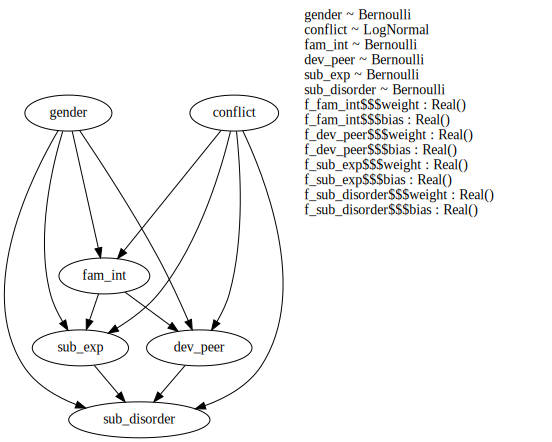

In [4]:
pyro.render_model(MediationModel(), render_distributions=True, render_params=True)

## Causal Query: average natural direct effect (ANDE)

Our query is somewhat convoluted, as it includes nesting counterfactuals. So, first, we define a model transformation parametrized by the names of a predictor and a mediator yields a model in which appropriate interventions have been performed. By intervening multiple times within the `MultiWorldCounterfactual` context we are creating, multiple worlds resulting from all combinations of interventions, which we will later use to answer our causal query.

In [5]:
class NaturalDirectEffectModel(pyro.nn.PyroModule):
    
    def __init__(self, causal_model: MediationModel):
        super().__init__()
        self.causal_model = causal_model

    @pyro.infer.config_enumerate
    def forward(self, x, x_prime):
        with MultiWorldCounterfactual(), \
                do(actions=dict(fam_int=(x, x_prime))), \
                do(actions=dict(sub_exp=lambda Z_: gather(Z_, IndexSet(fam_int={2})))), \
                pyro.plate("data", size=x.shape[0], dim=-1):

            ys = self.causal_model()
            ys_xprime = gather(ys, IndexSet(fam_int={2}, sub_exp={0}))  # y_x'
            ys_x = gather(ys, IndexSet(fam_int={1}, sub_exp={1}))  # y_x,z
            return ys_xprime - ys_x

We now apply this to the causal model we introduced, to obtain a new model representing the joint distribution over all factual and counterfactual variables necessary to estimate the ANDE (which are also sufficient for the estimation of ANIE):

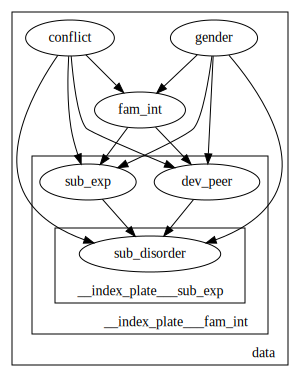

In [6]:
x0 = data["fam_int"].new_full((num_data,), 0.)
x1 = data["fam_int"].new_full((num_data,), 1.)

surrogate_model = MediationModel()
query_model = NaturalDirectEffectModel(surrogate_model)

pyro.render_model(NaturalDirectEffectModel(MediationModel()), model_args=(x0, x1))

## Causal Inference as Probabilistic Inference

Before attempting to compute the natural direct effect, we first learn the model's parameters. The first step is to condition the model on the data.

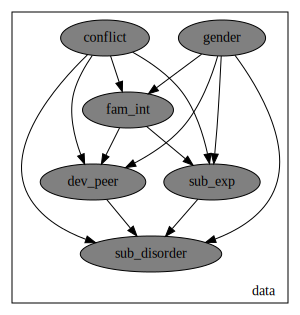

In [7]:
class ConditionedMediationModel(pyro.nn.PyroModule):
    def __init__(self, causal_model: MediationModel):
        super().__init__()
        self.causal_model = causal_model
        
    def forward(self, data):
        with condition(data=data), \
                pyro.plate("data", size=num_data, dim=-1):
            return self.causal_model()

conditioned_model = ConditionedMediationModel(surrogate_model)
pyro.render_model(conditioned_model, model_args=(data,))

Now we use the standard Pyro inferential tools (see [Pyro tutorials](https://pyro.ai/examples/) if this looks unclear). We implement maximum likelihood with stochastic variational inference and the Dirac-Delta variational approximation.

In [8]:
class LightningSVI(pl.LightningModule):
    def __init__(self, elbo: pyro.infer.elbo.ELBOModule, **optim_params):
        super().__init__()
        self.optim_params = dict(optim_params)
        self.elbo = elbo

    def configure_optimizers(self):
        return torch.optim.Adam(self.elbo.parameters(), **self.optim_params)

    def training_step(self, batch, batch_idx):
        return self.elbo(dict(zip(sorted(data.keys()), batch)))


guide = pyro.infer.autoguide.AutoDelta(conditioned_model)
elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide)

# initialize
elbo(data)

# fit
train_dataset = torch.utils.data.TensorDataset(*(v for k, v in sorted(data.items())))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=num_data)
svi = LightningSVI(elbo, lr=0.03)
trainer = pl.Trainer(max_epochs=max_epochs, log_every_n_steps=1)
trainer.fit(svi, train_dataloaders=train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rafal/miniconda3/envs/chirho/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name | Type       | Params
------------------------------------
0 | elbo | ELBOModule | 16    
------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


/home/rafal/miniconda3/envs/chirho/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Next, we use the expanded model defined previously to get the natural direct effect:

In [9]:
conditioned_query_model = condition(data=dict(fam_int=data["fam_int"], **covariates))(query_model)

discrete_posterior = pyro.infer.infer_discrete(first_available_dim=-8)(conditioned_query_model)

predictive = pyro.infer.Predictive(discrete_posterior, guide=guide, num_samples=num_samples, return_sites=["_RETURN"])
predictive_samples = predictive(x0, x1)

individual_NDE_samples = predictive_samples["_RETURN"]

Let's recap. For our query we are inspecting two things. (1) the average substance abuse in the world in which each subject's experimentation with drugs is fixed to be the way it was in the observational data and a family intervention is forced to be applied. (2) the average substance abuse in the world in which the family intervention was fixed to not occur (without fixing `sub_exp` to any particular value). We started with the goal of estimating the difference between somewhat complicated expected values, defined in terms of nested countefactuals (that is, ANDE). Yet, when it came to the implementation, evaluating this query is just indexing into the right two counterfactual worlds and inspecting the posterior predictive samples from these worlds. 

## Results

In [10]:
individual_NDE_mean = torch.mean(individual_NDE_samples.squeeze(), dim=0)
NDE_samples = torch.mean(individual_NDE_samples.squeeze(), dim=-1)  # avg over datapoints
NDE_mean = torch.mean(NDE_samples, dim=0)  # avg over posterior samples
print(NDE_mean)

tensor(-0.0357)


 In the [original blog post](https://statsnotebook.io/blog/analysis/mediation/), the NDA was $-.055$ with confidence interval $(-.12, .01)$. We mark these with vertical lines. Our MLE falls within the original confidence interval.

Text(-0.105, 48, 'Original estimate: -.055')

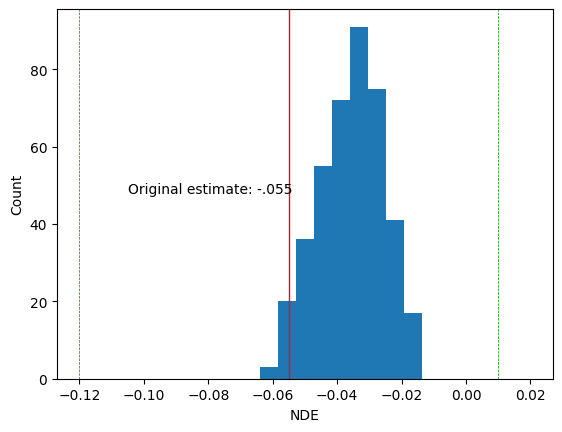

In [11]:
plt.hist(individual_NDE_mean.detach().cpu().numpy(), bins=25, range = (-.12, .02))
plt.axvline(-.055, color='red', linestyle='solid', linewidth=1)
plt.axvline(-.12, color='green', linestyle='dashed', linewidth=.5)
plt.axvline(.01, color='green', linestyle='dashed', linewidth=.5)
plt.xlabel('NDE')
plt.ylabel('Count')
plt.text(s = 'Original estimate: -.055', x= -.105, y =48)